In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
should_skip = True

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install -q gpustat gdown
  !pip install -q pytorch_lightning

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from pytorch_lightning import seed_everything

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule

In [9]:
# Set the seed
seed_everything(42)

Seed set to 42


42

In [10]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=100,
    batch_size=1,
)

In [11]:
slime = SLiME(
    use_self_attn=True,
).cuda()

/usr/local/lib/python3.8/dist-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [12]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=1,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:211: You called `self.log('mse_loss', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.


pred 0.08 0.08 ce loss 0.7 mse loss 0
pred -0.97 0.05 ce loss 0.59 mse loss 0
pred -1.62 0.04 ce loss 0.82 mse loss 0
pred -1.3 0.03 ce loss 0.6 mse loss 0
pred -0.9 0.03 ce loss 0.69 mse loss 0
pred -0.39 0.03 ce loss 0.63 mse loss 0
pred -0.2 0.03 ce loss 0.65 mse loss 0
pred -0.29 0.03 ce loss 0.67 mse loss 0
pred -0.42 0.02 ce loss 0.62 mse loss 0
pred -0.68 0.02 ce loss 0.68 mse loss 0
pred -0.84 0.02 ce loss 0.69 mse loss 0
pred -0.86 0.02 ce loss 0.59 mse loss 0
pred -0.9 0.02 ce loss 0.59 mse loss 0
pred -0.95 0.02 ce loss 0.7 mse loss 0
pred -0.86 0.02 ce loss 0.69 mse loss 0
pred -0.66 0.02 ce loss 0.6 mse loss 0
pred -0.56 0.02 ce loss 0.67 mse loss 0
pred -0.43 0.02 ce loss 0.62 mse loss 0
pred -0.45 0.02 ce loss 0.62 mse loss 0
pred -0.59 0.02 ce loss 0.67 mse loss 0
pred -0.67 0.02 ce loss 0.6 mse loss 0
pred -0.82 0.02 ce loss 0.69 mse loss 0
pred -0.84 0.02 ce loss 0.69 mse loss 0
pred -0.77 0.02 ce loss 0.6 mse loss 0
pred -0.74 0.03 ce loss 0.68 mse loss 0
pred -0.64 

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [13]:
slime.cuda(); 0

0

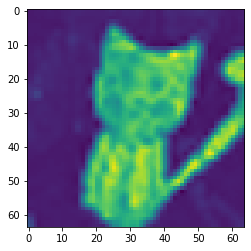

In [15]:
import matplotlib.pyplot as plt
plt.imshow(slime.latest_preds[-1].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,1])

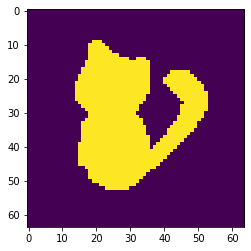

In [17]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  break

import matplotlib.pyplot as plt
for i in range(len(out_mask)):
  plt.imshow(out_mask[i].reshape((64,64)))
  plt.show()

(970, 4096)
sums
[ 6.0644817  6.417745   6.435933  ... 18.888979  19.173     18.592686 ]
[0.9404321  0.94527555 0.94039744 ... 1.0578438  1.0700821  1.0631725 ]
[0.82611424 0.8578172  0.8570877  ... 1.1852278  1.2035055  1.1774029 ]


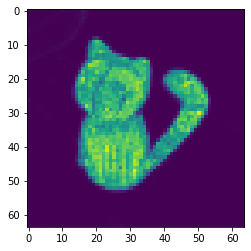

In [18]:
# visualize self-attn maps

self_attn_maps = slime.latest_selfs

# pick a random token to visualize

batch_num = 0
layer_num = 0

mask = out_mask[batch_num].astype(bool)==1

layer = self_attn_maps[layer_num]
num_tokens = layer.shape[1]
token_num = random.randint(0, num_tokens - 1)

im_dims = int(math.sqrt(layer.shape[-1]))

print(layer[batch_num,mask].shape)

raw_map = layer[batch_num]
# make attn map cols sum to 1
attn_map = (raw_map / raw_map.sum(axis=1)) 
big_attn_map = attn_map
# raise matrix to power of 2 (with matrix multiplication)
for i in range(5):
    big_attn_map = big_attn_map @ attn_map
print("sums")
print(raw_map.sum(axis=1))
print(attn_map.sum(axis=1))
print(big_attn_map.sum(axis=1))

final_attn_map = attn_map[mask].mean(axis=0).reshape(im_dims, im_dims).copy()
#  = attn_map / attn_map.max()
# attn_map[token_num // im_dims, token_num % im_dims] = 1.0

plt.imshow(final_attn_map)

In [19]:
eigenvals, eigenvectors = np.linalg.eig(attn_map)
eigenvals = eigenvals.real
print(eigenvectors)

[[-7.6488233e-03+0.0000000e+00j -2.3873804e-02+0.0000000e+00j
  -5.2597500e-02+0.0000000e+00j ...  8.6181314e-04+3.9076560e-05j
   8.6181314e-04-3.9076560e-05j  2.8895019e-03+0.0000000e+00j]
 [-8.0943769e-03+0.0000000e+00j -2.5474217e-02+0.0000000e+00j
  -6.0841314e-02+0.0000000e+00j ...  5.5698091e-03-1.1480585e-04j
   5.5698091e-03+1.1480585e-04j  1.3028955e-02+0.0000000e+00j]
 [-8.1173154e-03+0.0000000e+00j -2.5779383e-02+0.0000000e+00j
  -6.2256392e-02+0.0000000e+00j ... -9.5133677e-05-9.2549616e-04j
  -9.5133677e-05+9.2549616e-04j -5.0844969e-03+0.0000000e+00j]
 ...
 [-2.3823708e-02+0.0000000e+00j  5.2433172e-03+0.0000000e+00j
   1.0191839e-03+0.0000000e+00j ...  1.4945782e-02-1.0100014e-02j
   1.4945782e-02+1.0100014e-02j -1.0401326e-02+0.0000000e+00j]
 [-2.4181934e-02+0.0000000e+00j  5.3181243e-03+0.0000000e+00j
   1.0337075e-03+0.0000000e+00j ... -2.1411300e-02+7.3692259e-05j
  -2.1411300e-02-7.3692259e-05j -1.2518555e-02+0.0000000e+00j]
 [-2.3450013e-02+0.0000000e+00j  5.05073

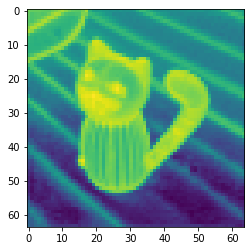

In [20]:
eigenvecs = eigenvectors[:,0].real.reshape(im_dims, im_dims)
plt.imshow(eigenvecs)